<a href="https://colab.research.google.com/github/surajTade/Hindi-OCR/blob/main/Hindi_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pwd

/content


In [ ]:
# %cd drive/MyDrive/hindi_project/

In [ ]:
# !mkdir hindi_words

In [ ]:
# %cd hindi_words

In [ ]:
!unzip drive/MyDrive/hindi_project/hindi-words-dataset.zip

In [ ]:
# !pip install git+git://github.com/fchollet/keras.git --upgrade

In [ ]:
import os
import cv2
import numpy as np
import string
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional

from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax

from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import tqdm
from collections import Counter

from PIL import Image

In [ ]:
# tf.__version__
!ls

drive	  hindi_vocab.txt  Readme.txt	test.txt   val.txt
HindiSeg  lexicon.txt	   sample_data	train.txt


In [ ]:
def generate_data(path):
  # Function that splits training path and annotations in 2 different lists.
  _path = []
  _label = []
  with open(path) as _data:
    for line in _data:
      temp = np.array(line.split())
      _path.append(temp[0])
      _label.append(temp[1])
  return _path, _label

In [ ]:
train_path, train_label = generate_data("train.txt")
# train_path[:10], train_label[:10]

In [ ]:
val_path, val_label = generate_data("val.txt")
# val_path[:10], val_label[:10]

In [ ]:
# Code that generates a list of all the available characters in the dataset.
temp_vocab = []
with open("hindi_vocab.txt") as hindi_voc:
  for char in hindi_voc:
    temp = np.array(char.split("\n"))
    temp_vocab.append(temp[0])
vocab = set("".join(map(str, temp_vocab)))
print(sorted(vocab))
# print(len(vocab))

['-', 'ँ', 'ं', 'ः', 'ऄ', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ऌ', 'ऍ', 'ऎ', 'ए', 'ऐ', 'ऑ', 'ऒ', 'ओ', 'औ', 'क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'ऩ', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ऱ', 'ल', 'ळ', 'ऴ', 'व', 'श', 'ष', 'स', 'ह', '़', 'ऽ', 'ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'ॄ', 'ॅ', 'ॆ', 'े', 'ै', 'ॉ', 'ॊ', 'ो', 'ौ', '्', 'ॐ', '॑', '॒', '॓', '॔', 'क़', 'ख़', 'ग़', 'ज़', 'ड़', 'ढ़', 'फ़', 'य़', 'ॠ', 'ॡ', 'ॢ', '।', '॥', '०', '१', '२', '३', '४', '५', '६', '७', '८', '९', '॰', 'ॱ', 'ॲ', 'ॻ', 'ॼ', 'ॽ', 'ॾ', 'ॿ']


In [ ]:
Counter("".join(map(str, temp_vocab)))

Counter({'-': 398,
         'ँ': 176,
         'ं': 2414,
         'ः': 20,
         'ऄ': 1,
         'अ': 559,
         'आ': 373,
         'इ': 291,
         'ई': 212,
         'उ': 260,
         'ऊ': 44,
         'ऋ': 6,
         'ऌ': 3,
         'ऍ': 2,
         'ऎ': 1,
         'ए': 391,
         'ऐ': 18,
         'ऑ': 18,
         'ऒ': 1,
         'ओ': 142,
         'औ': 19,
         'क': 2714,
         'ख': 493,
         'ग': 1280,
         'घ': 156,
         'ङ': 11,
         'च': 760,
         'छ': 193,
         'ज': 1296,
         'झ': 128,
         'ञ': 43,
         'ट': 1031,
         'ठ': 173,
         'ड': 726,
         'ढ': 118,
         'ण': 293,
         'त': 2507,
         'थ': 246,
         'द': 1442,
         'ध': 490,
         'न': 2835,
         'ऩ': 4,
         'प': 1757,
         'फ': 410,
         'ब': 1243,
         'भ': 441,
         'म': 2104,
         'य': 1640,
         'र': 4452,
         'ऱ': 3,
         'ल': 2162,
         'ळ': 3,
         'ऴ': 3,
      

In [ ]:
char_list = sorted(vocab)

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
        
    return dig_lst

In [ ]:
encode_to_labels("छू")

[27, 64]

In [ ]:
len(train_path), len(val_path)

(69853, 12708)

In [ ]:
max_label_len = max([len(str(text)) for text in temp_vocab])
max_label_len

23

In [ ]:
class My_Generator(Sequence):


  def __init__(self, image_filenames, labels, batch_size):
    self.image_filenames, self.labels = image_filenames, labels
    self.batch_size = batch_size

  def __len__(self):
    return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

  def __getitem__(self, idx):
    batch_paths = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
    batch_texts = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        
    images = []
    training_txt = []
    train_label_length = []
    train_input_length = []

    for im_path, text in zip(batch_paths, batch_texts):
      try:
        text = str(text).strip()
        img = cv2.cvtColor(cv2.imread("HindiSeg/"+im_path), cv2.COLOR_BGR2GRAY)   

        ### actually returns h, w
        h, w = img.shape

        ### if height less than 32
        if h < 32:
          add_zeros = np.ones((32-h, w)) * 255
          img = np.concatenate((img, add_zeros))
          h = 32

        ## if width less than 128
        if w < 128:
          add_zeros = np.ones((h, 128-w)) * 255
          img = np.concatenate((img, add_zeros), axis=1)
          w = 128

        ### if width is greater than 128 or height greater than 32
        if w > 128 or h > 32:
          img = cv2.resize(img, (128, 32))

          img = np.expand_dims(img , axis = 2)

          # Normalize each image
          img = img / 255.

          images.append(img)
          training_txt.append(encode_to_labels(text))
          train_label_length.append(len(text))
          train_input_length.append(31)
      except:
        pass

    return [np.array(images), 
               pad_sequences(training_txt, maxlen=max_label_len, padding='post', value=len(char_list)), 
               np.array(train_input_length), 
               np.array(train_label_length)], np.zeros(len(images))

In [ ]:
train_path[:1], train_label[:1]

(['HindiSeg/train/8/251/21.jpg'], ['केंद्रों'])

In [ ]:
!nvidia-smi

Fri Jul 15 09:13:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    25W /  70W |   5358MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
batch_size = 256
train_generator = My_Generator(train_path, train_label, batch_size)
val_generator = My_Generator(val_path, val_label, batch_size)

In [ ]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32, 128, 1))

conv_1 = Conv2D(16, (3,3), activation = 'relu', padding='same')(inputs)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(32, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

conv_3 = Conv2D(64, (3,3), activation = 'relu', padding='same')(pool_2)
conv_4 = Conv2D(64, (3,3), activation = 'relu', padding='same')(conv_3)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(64, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(64, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(64, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(CuDNNLSTM(128, return_sequences=True))(squeezed)
blstm_2 = Bidirectional(CuDNNLSTM(128, return_sequences=True))(blstm_1)

outputs = Dense(len(char_list) + 1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [ ]:
act_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 32, 128, 16)       160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 32, 32)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 32, 64)         18496 

In [ ]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
loss_out = Lambda(ctc_lambda_func, 
                  output_shape=(1,), 
                  name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [ ]:
file_path = "C_LSTM_best.hdf5"

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'Adam')

checkpoint = ModelCheckpoint(filepath=file_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

callbacks_list = [checkpoint]

In [ ]:
epochs = 25

Hindi = model.fit(train_generator, 
                    epochs = epochs,
                    steps_per_epoch = len(train_path) // batch_size,
                    validation_data=val_generator,
                    validation_steps = len(val_path) // batch_size,
                    verbose = 1,
                    callbacks = callbacks_list,
                    shuffle=True)

Epoch 1/25
272/272 [==============================] - ETA: 0s - loss: 23.6672
Epoch 1: val_loss improved from inf to 21.99855, saving model to C_LSTM_best.hdf5
272/272 [==============================] - 314s 1s/step - loss: 23.6672 - val_loss: 21.9985
Epoch 2/25
272/272 [==============================] - ETA: 0s - loss: 20.4293
Epoch 2: val_loss did not improve from 21.99855
272/272 [==============================] - 283s 1s/step - loss: 20.4293 - val_loss: 26.6857
Epoch 3/25
272/272 [==============================] - ETA: 0s - loss: 15.2880
Epoch 3: val_loss did not improve from 21.99855
272/272 [==============================] - 267s 983ms/step - loss: 15.2880 - val_loss: 22.3053
Epoch 4/25
272/272 [==============================] - ETA: 0s - loss: 8.8308
Epoch 4: val_loss improved from 21.99855 to 8.56874, saving model to C_LSTM_best.hdf5
272/272 [==============================] - 269s 989ms/step - loss: 8.8308 - val_loss: 8.5687
Epoch 5/25
272/272 [==============================] -

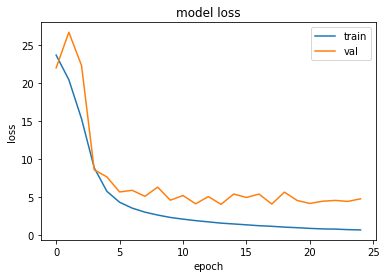

In [ ]:
plt.plot(Hindi.history['loss'])
plt.plot(Hindi.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Testing the model.

1. Load the weights from the trained model.
2. Send the image for testing.

In [ ]:
def pre_process_image(path):

  img = cv2.cvtColor(cv2.imread("HindiSeg/"+path), cv2.COLOR_BGR2GRAY)
  # img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
  ### actually returns h, w
  h, w = img.shape

  ### if height less than 32
  if h < 32:
    add_zeros = np.ones((32-h, w)) * 255
    img = np.concatenate((img, add_zeros))
    h = 32

  ## if width less than 128
  if w < 128:
    add_zeros = np.ones((h, 128-w)) * 255
    img = np.concatenate((img, add_zeros), axis=1)
    w = 128

  ### if width is greater than 128 or height greater than 32
  if w > 128 or h > 32:
    img = cv2.resize(img, (128, 32))

    
  img = np.expand_dims(img , axis = 2)

  # Normalize each image
  img = img / 255.
    
  return img

In [ ]:
# Loading the weights of pre-trained model.
act_model.load_weights('C_LSTM_best.hdf5')

In [ ]:
def predict_output(img):
    # predict outputs on validation images
    prediction = act_model.predict(np.array([img]))
    ## shape (batch_size, num_timesteps, vocab_size)

    # use CTC decoder
    out = K.get_value(K.ctc_decode(prediction, 
                                   input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                                   greedy=True)[0][0])

    ## get the final text    
    for x in out:

        print("predicted text = ", end = '')

        for p in x:

            if int(p) != -1:
                print(char_list[int(p)], end = '')
        
        print('\n')

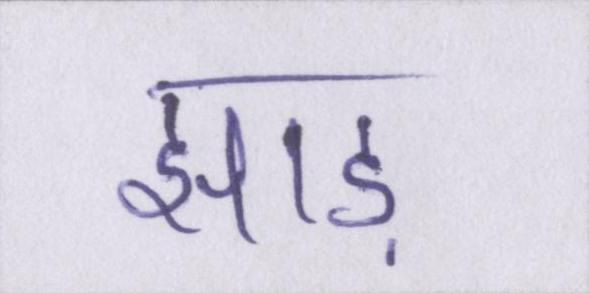



predicted text = झाड़



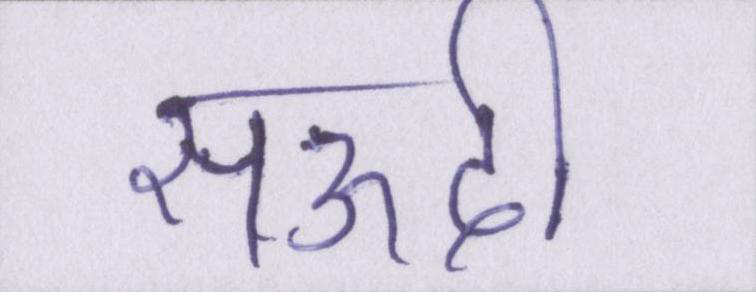



predicted text = सऊदी



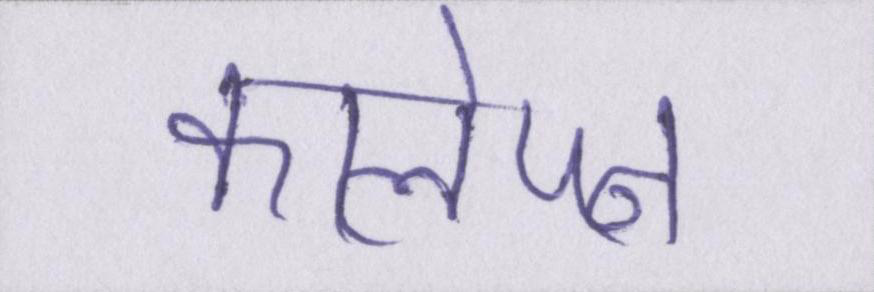



predicted text = कालेपन



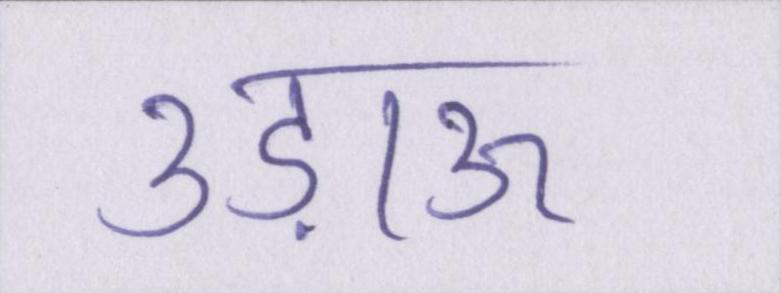



predicted text = उड़ाऊ



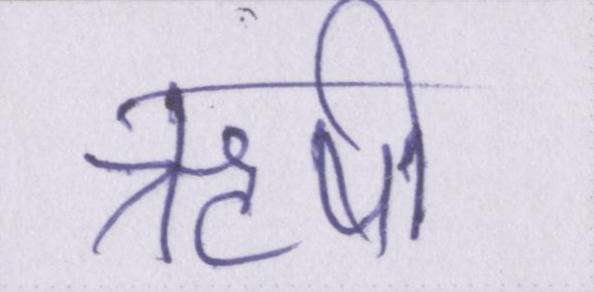



predicted text = ॠ्हषि



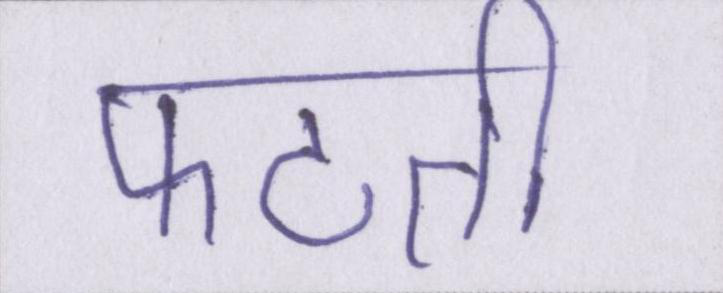



predicted text = फठती



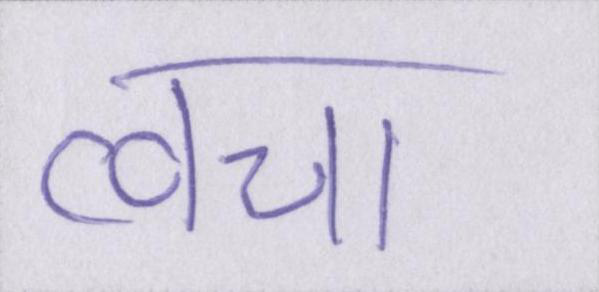



predicted text = तचा



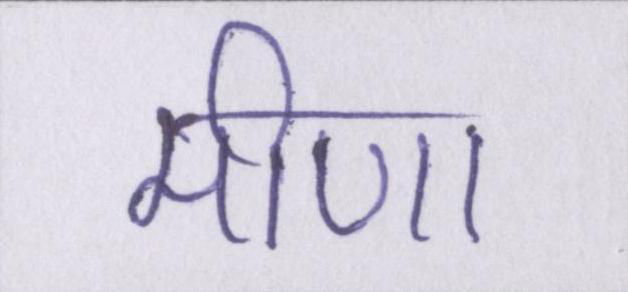



predicted text = मीणा



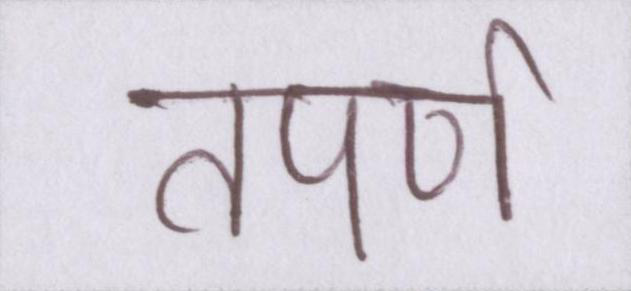



predicted text = तपर्ण



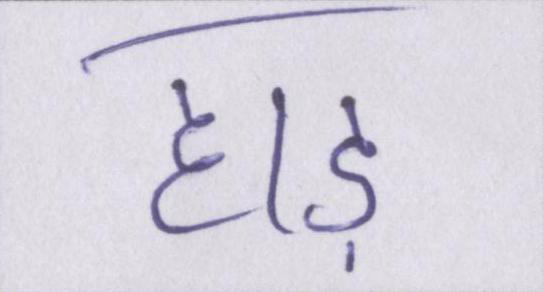



predicted text = हा़



In [ ]:
from IPython.display import display
from random import randrange

for i in range(10):
    index = randrange(len(val_path))
    im = Image.open("HindiSeg/"+val_path[index])
    display(im)

    print("\n")

    test_img = pre_process_image(val_path[index])
    predict_output(test_img)

In [ ]:
# im = Image.open("/content/test_1.jpeg")
# display(im)
# test_img = pre_process_image("/content/test_1.jpeg")
# predict_output(test_img)